<a href="https://colab.research.google.com/github/adesam146/nlpcw/blob/master/model_design_and_bayesian_optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Introduction
Note to marker: Please display this in colab rather than as a pdf or in jupyter.

This document gives an overview of the thought process behind our final model. To see the model itself skip to the "Final Model" subsection in the table of contents. 

We used GloVe embeddings and a CNN for our final classifiers but we also did some preliminary investigation into BERT and ELMO embeddings as well as traditional machine learning classifiers. This work would break up the flow of this notebook but can be found in BERT_and_ELMO.ipynb and SVMs_vs_NN.ipynb. 

## Imports

In [0]:
!pip install -U spacy ftfy torchtext
!python -m spacy download en
!pip install -U textblob #Sentiment analysis
!python -m textblob.download_corpora
!pip install scikit-optimize
!pip install pandas

In [0]:
#DONWLOAD GLOVE vectors and unzip

!wget http://nlp.stanford.edu/data/glove.twitter.27B.zip
!unzip glove.twitter.27B.zip

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data import sampler
from torch import autograd
import spacy
from torchtext import data
from torchtext import datasets as nlp_dset
import random
from sklearn.utils import resample
import numpy as np
import pandas as pd
from textblob import TextBlob
import string
from sklearn import metrics
from skopt import gp_minimize #Beyesian optimization
import torchvision.transforms as T
import nltk

#initialize spaCy
nlp_spaCy = spacy.load('en', disable=["tagger", "parser", "ner"])


#Create list of stopwords
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from nltk.corpus import stopwords
nltk.download("stopwords")
stops_nltk = list(stopwords.words('english'))
stops_sklearn = list(ENGLISH_STOP_WORDS)
STOPWORDS = list(set(stops_nltk + stops_sklearn))


BATCH_SIZE = 128

#Fix all seeds
SEED = 0

def set_seed(seed=SEED):
    """Helper function to set all seeds to make results reproducible"""
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.cuda.manual_seed(seed)
set_seed()


#Set device = cuda 
GPU = True
device_idx = 0
if GPU:
    device = torch.device("cuda:"+str(device_idx) if torch.cuda.is_available() else "cpu")
else:
    device = torch.device("cpu")

print("Using device:", device)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Using device: cuda:0


In [0]:
# Load datafiles from own google drive (or local)

# EDIT AS NECESSARY:
#################
from google.colab import drive
drive.mount('/content/drive')
One_drive = """/content/drive/My Drive/colab_data/"""



train_fp = One_drive + "offenseval-training-v1.tsv"

#Store data in dataframe for later
train_df = pd.read_csv(train_fp, delimiter="\t")

#Import test datasets:
test_fp_A = One_drive + "testset-taska.tsv"
test_fp_B = One_drive + "testset-taskb.tsv"
test_fp_C = One_drive + "test_set_taskc.tsv"

#################

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Preprocess Data

In [0]:
def tokenize_params(text, params):
    """tokenizes, and optionally also:
        1) replaces words with their lemmatized forms
        2) removes punctuation
        3) removes english stopwords. 
    """
    
    lemmatize = params.get("lemmatize")
    rem_punct = params.get("rem_punct")
    rem_stopwords = params.get("rem_stopwords")
    
    #deal with stopwords
    if rem_stopwords:
        stopwords = STOPWORDS
    else:
        stopwords = []
    
    #deal with no punctuation
    if rem_punct:
        stoptokens = [x for x in list(string.punctuation) if x not in list("#$&*@")]
        stoptokens += stopwords
    else:
        stoptokens = stopwords 
    #stoptokens will be removed from tokens
        
    #replace each sentence with its lemmatized counterpart
    if not lemmatize:
        result = [tok.text for tok in nlp_spaCy.tokenizer(text) if tok.text not in stoptokens]
    else:
        #otherwise: lemmatize
        tweet = nlp_spaCy(text)  #SpaCy tokenizes and does POS and lemmatization on tokens 
        tokens = []
        for counter, token in enumerate(tweet):
            if token.lemma_ == "-PRON-":         #treat pronouns differently as SpaCy replaces all of them with "-PRON-"
                tokens.append(token.text)        #which therefore becomes a common token that biases results
            #For everything else, add the lemma:
            else:
                tokens.append(token.lemma_)
        result = [tok for tok in tokens if tok not in stoptokens]
    return result

def tokenizer(text):
    """wrapper for tokenize so it can be used in torchtext Field creation. It takes the 
    current global varaiable TOKENIZE_PARAMS"""
    try:
        params = TOKENIZE_PARAMS
    except NameError:
        print("You must initialize the global variable TOKENIZE_PARAMS")
        raise NameError
    return tokenize_params(text, params)

In [0]:
# Add sentiment
def add_sentiment(h, ids):
    """Calculate tweet sentiment and concatenate this feature onto the 
    feature matrix (typically just before the fully connected layers). 
    The feature matrix dimensions will be changed as follows: 
        (B, O) -> (B, O + 2)
        where B = batch size, O = out channels
    """

    assert type(ids) == torch.Tensor, "If sentiment == True, ids must be of type tensor"

    #retrieve tweets using id:
    tweets = train_df[train_df["id"].isin(ids.cpu().numpy())]

    sentiments = []
    subjectivities = []
    
    #extract "sentiment" and "subjectivity" according to TextBlob:
    sentiments, subjectivities = get_sentiment_v(tweets["tweet"].values)
    
    sentiments = torch.cuda.FloatTensor(sentiments, device=device).unsqueeze(1)
    subjectivities = torch.cuda.FloatTensor(subjectivities, device=device).unsqueeze(1)
    
    
    h = torch.cat([h, sentiments, subjectivities], dim=1)
    #(batch size, out channels + 2)

    
    return h

def get_sentiment(text):
    """Gets sentiment and subjectivity of text"""
    blob = TextBlob(text)
    sentiment = blob.sentiment.polarity
    subjectivity = blob.sentiment.subjectivity
    return sentiment, subjectivity

#create vectorized implementation for speed
get_sentiment_v = np.vectorize(get_sentiment, otypes = ["float", "float"], doc= "vectorized version of get_sentiment()")

## Candidate Models

We had a series of candidate NN classifiers which are detailed here - see the report for more details. 

For the final classifier, skip to the "Final Model" subsection.

In [0]:
#embedding (lookup layer) layer
class BidirectionalGRU(nn.Module):
    """Classifier consisting of Bidirectional GRU (i.e. RNN with memory) and 
    followed by two fully connected layers.
    
    NOTE: this model was not used in any of the subtasks (see the report for more detail)"""
    
    def __init__(self, vocab, embedding_dim, window_size, out_channels = 128, 
                 dropout=0.5, n_hidden = 64, num_classes=2, batch_size = BATCH_SIZE, 
                 sentiment= False, ids=None):
        
        super(BidirectionalGRU, self).__init__()
        
        self.sentiment = sentiment
        if sentiment == True:
            added_features = 2 #This will update number of fully connected neurons
        else:
            added_features = 0
            
            
        self.n_hidden = n_hidden
        self.batch_size = BATCH_SIZE
        self.num_layers = 1 #number of GRU layers
        
        self.vocab = vocab
        self.embedding = nn.Embedding(len(vocab), embedding_dim)
        self.embedding.weight.data.copy_(vocab.vectors) # copies pre-trained word vectors
        
        self.bi_gru =  torch.nn.GRU(input_size=embedding_dim, hidden_size=n_hidden, 
                                    num_layers= self.num_layers, batch_first=False, 
                                    bidirectional=True)
        self.hidden = self.init_hidden(self.batch_size)
    
        #Fully connected layer will convert GRU output into a label
        # number of input features is 2 * n_hidden since GRU is bidirectional
        
        self.fc1 = nn.Linear( 2 * n_hidden + added_features, 16)
        self.fc2 = nn.Linear(16, 1 if num_classes == 2 else num_classes)

        #Activation: use leaky relu
        self.lReLU = nn.LeakyReLU(negative_slope=0.05, inplace=False)
        
        #Dropout
        self.dropout = nn.Dropout(dropout)
        
        #Kaming normalization
        nn.init.kaiming_normal_(self.fc1.weight)
        nn.init.kaiming_normal_(self.fc2.weight)

    def init_hidden(self, batch_size = BATCH_SIZE):
        return torch.zeros((self.num_layers * 2, batch_size, self.n_hidden), device=device)
        
        
    def forward(self, x, ids=None):
        embedded = self.embedding(x)
        #(batch size, max sent length, embedding dim)
        embedded = self.embedding(x).view((embedded.shape[1], embedded.shape[0], -1))
        #(max sent length, batch size, embedding dim)
        
        bi_output, self.hidden = self.bi_gru(embedded, self.hidden)
        
        # add sentiment?
        
        #Just take final value of bi_output:
        h = self.lReLU(bi_output[-1])
        
        if self.sentiment: #then add sentiment
            h = add_sentiment(h, ids)
            
        h = self.fc1( self.dropout(h))
        
        h = self.fc2( self.dropout(h))
        
        #h = self.fc2(self.dropout(h))
        return h
   

In [0]:
#embedding (lookup layer) layer
class OriginalClassifierGloVe(nn.Module):
    """Glove Embeddings w. 2d convolution.
    
    NOTE: This model was used for subtask C but a more complex version was 
    used for subtasks A and B"""
    
    def __init__(self, vocab, embedding_dim, window_size, out_channels, dropout, num_classes=2):
        
        super(OriginalClassifierGloVe, self).__init__()
        
        
        self.vocab = vocab
        self.embedding = nn.Embedding(len(vocab), embedding_dim)
        self.embedding.weight.data.copy_(vocab.vectors) # copies pre-trained word vectors

        self.conv = nn.Conv2d(in_channels=1, out_channels=out_channels, kernel_size=(window_size, embedding_dim))

        self.dropout = nn.Dropout(dropout)

        self.fc = nn.Linear(out_channels, 1 if num_classes == 2 else num_classes)
        
        self.lReLU = nn.LeakyReLU(negative_slope=0.05, inplace=False)
        
        #Kaming normalization
        nn.init.kaiming_normal_(self.conv.weight)
        nn.init.kaiming_normal_(self.fc.weight)

        
        
    def forward(self, x, ids=None):
        
        embedded = self.embedding(x)
                
        #(batch size, max sent length, embedding dim)
        
        #images have 3 RGB channels 
        #for the text we add 1 channel
        embedded = embedded.unsqueeze(1)
        
        #(batch size, 1, max sent length, embedding dim)
        
        feature_maps =  self.lReLU(self.conv(embedded).squeeze(3))
        # (batch size, out_channels, max sent length - window size +1, 1)
        # -> (batch size, out_channels, max sent length - window size +1)
           
        #the max pooling layer
        pooled = F.max_pool1d(feature_maps, feature_maps.shape[2]).squeeze(2)
        # (batch size, out_channels)      
        
        # Do batch normalize pooled then at sentiment
        
        return self.fc(self.dropout(pooled))

In [0]:
#embedding (lookup layer) layer
class SimpleClassifierGloVe(nn.Module):
    """Iteration on OriginalClassifierGloVe(). This has a single convolution 
    and two FC layers for classification. 
    
    It also allows the ability to concatenate the tweet sentiment to the input to the 
    FC layers. Other than this, it is identical to OriginalClassifierGloVe
    
    NOTE: This model was one of the two candidates in the Bayesian optimization below 
    (although it was not used for any of the subtasks)."""
    
    def __init__(self, vocab, embedding_dim, window_size, out_channels, dropout, 
                 num_classes=2, sentiment=False, n_hidden = 64):
        
        super(SimpleClassifierGloVe, self).__init__()
        self.sentiment = sentiment
        if sentiment == True:
            added_features = 2
        else:
            added_features = 0
            
        self.vocab = vocab
        self.embedding = nn.Embedding(len(vocab), embedding_dim)
        self.embedding.weight.data.copy_(vocab.vectors) # copies pre-trained word vectors

        self.conv = nn.Conv2d(in_channels=1, out_channels=out_channels, kernel_size=(window_size, embedding_dim))

        self.dropout = nn.Dropout(dropout)
        
        self.fc1 = nn.Linear(out_channels + added_features, n_hidden)
        self.fc2 = nn.Linear(n_hidden, 1 if num_classes == 2 else num_classes)
        
        
        self.lReLU = nn.LeakyReLU(negative_slope=0.05, inplace=False)
        
        #Kaming normalization
        nn.init.kaiming_normal_(self.conv.weight)
        nn.init.kaiming_normal_(self.fc1.weight)
        nn.init.kaiming_normal_(self.fc2.weight)
        
        
    def forward(self, x, ids = None):
        
        embedded = self.embedding(x)
            
        #(batch size, max sent length, embedding dim)
        
        
        #images have 3 RGB channels 
        #for the text we add 1 channel
        embedded = embedded.unsqueeze(1)
        #(batch size, 1, max sent length, embedding dim)
        
        feature_maps =  self.lReLU(self.conv(embedded).squeeze(3))
        # (batch size, out_channels, max sent length - window size +1, 1)
        # -> (batch size, out_channels, max sent length - window size +1)
           
        #the max pooling layer
        h = F.max_pool1d(feature_maps, feature_maps.shape[2]).squeeze(2)
        # (batch size, out_channels) 
        
        if self.sentiment: #then add sentiment
            h = add_sentiment(h, ids)
            
        h = self.lReLU(self.fc1( self.dropout(h)))
        
        h = self.fc2(self.dropout(h))
       
        
        return h


In [0]:
class ClassifierGloVeDeep(nn.Module):
    """Alteration to SimpleClassifierGloVe().
    This has a single 2d convolution and 5 fully connected layers rather than two
    
    Other than this, it is identical to SimpleClassifierGloVe()
    
    NOTE: This model was one of the two candidates in the Bayesian optimization below 
    (although it was not used for any of the subtasks)."""
    
    def __init__(self, vocab, embedding_dim, window_size, out_channels = 128, 
                 dropout=0.5, n_hidden = 64, num_classes=2, sentiment=False):
        
        super(ClassifierGloVeDeep, self).__init__()
        self.sentiment = sentiment
        if sentiment == True:
            added_features = 2 #This will update number of fully connected neurons
        else:
            added_features = 0
            
        self.vocab = vocab
        self.embedding = nn.Embedding(len(vocab), embedding_dim)
        self.embedding.weight.data.copy_(vocab.vectors) # copies pre-trained word vectors

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=out_channels, kernel_size=(window_size, embedding_dim))
        
        self.fc1 = nn.Linear(out_channels + added_features, n_hidden[0])
        self.fc2 = nn.Linear(n_hidden[0], n_hidden[1])
        self.fc3 = nn.Linear(n_hidden[1], n_hidden[2])
        self.fc4 = nn.Linear(n_hidden[2], n_hidden[3])
        self.fc5 = nn.Linear(n_hidden[3], n_hidden[4])
        self.fc6 = nn.Linear(n_hidden[4], 1 if num_classes == 2 else num_classes)
        
        #Activation: use leaky relu
        self.lReLU = nn.LeakyReLU(negative_slope=0.05, inplace=False)
        
        #Dropout
        self.dropout = nn.Dropout(dropout)
        
        #Kaming normalization
        nn.init.kaiming_normal_(self.conv1.weight)
        nn.init.kaiming_normal_(self.fc1.weight)
        nn.init.kaiming_normal_(self.fc2.weight)
        
        
    def forward(self, x, ids=None):
        
        embedded = self.embedding(x)
                
       
        embedded = embedded.unsqueeze(1)
       
        
        feature_maps =  self.lReLU(self.conv1(embedded).squeeze(3))
        
       
        h = F.max_pool1d(feature_maps, feature_maps.shape[2]).squeeze(2)
        
        if self.sentiment: #then add sentiment
            h = add_sentiment(h, ids)
        
        h = self.lReLU(self.fc1( self.dropout(h)))
        h = self.lReLU(self.fc2( self.dropout(h)))
        h = self.lReLU(self.fc3( self.dropout(h)))
        h = self.lReLU(self.fc4( self.dropout(h)))
        h = self.lReLU(self.fc5( self.dropout(h)))
        h = self.fc6( self.dropout(h))
        
        
        return h
   

## Helper Functions

In [0]:
#Helper functions to run training routine, calculate metrics etc.
def check_accuracy(task_header, loader, model, conf=False, RNN=False, verbose = True, ret_optim_metric=False):
    """
    Note at the moment this function assumes the batch size is equal to the 
    number of data in the loader when calculating the confusion matrix
    """
    num_correct = 0
    num_samples = 0
    bayesian_metric = None
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for idx, batch in enumerate(loader):
            x, y = batch.tweet, getattr(batch, task_header)
            y = y.view(-1, 1)
                
            x = x.to(device=device, dtype=torch.long)  # move to  GPU
            y = y.to(device=device, dtype=torch.long)
            
            if RNN:
                #Must zero all of the accumalated hidden state for the RNN
                model.hidden = model.init_hidden(batch.batch_size)
                
            logits = model(x, ids = batch.id)
            if task_header == 'subtask_c':
                pred_prob = F.softmax(logits, dim=1)
                pred_1 = torch.argmax(pred_prob, dim=1).view(-1, 1)
            else:
                pred_prob = torch.sigmoid(logits)
                pred_1 = (pred_prob > 0.5).type(torch.long)
              
            num_correct += (pred_1 == y).sum()
            num_samples += pred_prob.size(0)
            
            # move to CPU to prevent memory overflow and calculate metrics
            x = x.to(device="cpu", dtype=torch.long)
            y = y.to(device="cpu", dtype=torch.long).numpy()
            pred_1 = pred_1.to(device="cpu", dtype=torch.long).numpy()
            
            
        acc = float(num_correct) / num_samples
        if conf:
            confusion = metrics.confusion_matrix(y, pred_1)
            clas_rep = metrics.classification_report(y, pred_1, output_dict =ret_optim_metric)
            kappa = "Kappa: {:.4f}".format(metrics.cohen_kappa_score(y, pred_1))
            if ret_optim_metric:
                bayesian_metric = optim_metric(clas_rep)
        else:
            total_metric = None
        if verbose:
            print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
            print(confusion)
            print(clas_rep)
            print(kappa)
    return bayesian_metric
            
def optim_metric(clas_rep):
    """calculate Bayesian Optimization metric"""
    f1_1 = clas_rep['0']["f1-score"]
    f1_2 = clas_rep['1']["f1-score"]
    total = np.sqrt(f1_1 * f1_2)
    return total

def check_loss(task_header, loader, model, loss_fn, RNN=False):
    model.eval()
    with torch.no_grad():
        loss = 0
        for idx, batch in enumerate(loader):
            x, y = batch.tweet, getattr(batch, task_header)

            x = x.to(device=device, dtype=torch.long) 
            y = y.to(device=device, dtype=torch.long if task_header == 'subtask_c' else torch.float)
            
            if RNN:
                #Must zero all of the accumalated hidden state for the RNN
                model.hidden = model.init_hidden(batch.batch_size)
                
            logits = model(x, ids= batch.id)

            loss += loss_fn(logits, y.view(-1,) if isinstance(loss_fn, nn.CrossEntropyLoss) else y.view(-1, 1))

    return loss/len(loader)
      

def train_helper(task_header, model, optimizer, train_loader, 
               valid_loader, epochs=1, RNN = False, loss_fn=F.binary_cross_entropy_with_logits, 
                 print_every=50, verbose = True, ret_optim_metric=False):
    """
    Train a model
    
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: Nothing, but prints model accuracies during training.
    """
    #sets seeds to make results reproducible
    set_seed()
    
    model = model.to(device=device)  # move the model parameters to GPU
    
    training_losses = []
    validation_losses = []
    optimizing_metric = []
    try:
        for epoch in range(epochs):
            if verbose:
                print("Epoch:", epoch)
            total_loss = 0
            for batch_idx, batch in enumerate(train_loader):

                model.train()  # put model to training mode
                optimizer.zero_grad()
                inputs, targets = batch.tweet, getattr(batch, task_header)
                
                if RNN:
                    #Must zero all of the accumulated hidden states for the GRU
                    model.hidden = model.init_hidden(batch.batch_size)
                
                
                x = inputs.to(device=device, dtype=torch.long)  # move to device, e.g. GPU
                y = targets.to(device=device, dtype=torch.long if task_header == 'subtask_c' else torch.float) #this should be a float cross entropy
                #x = inputs
                #y = targets
                logits = model(x, ids = batch.id)
                
                # When using cross_entropy the targets need to have a shape (N,)
                # However, for BCEWithLogits they just need
                # to have the same shape as the logits
                loss = loss_fn(logits, y.view(-1,) if isinstance(loss_fn, nn.CrossEntropyLoss) else y.view(-1, 1))
                # Zero out all of the gradients for the variables which the optimizer
                # will update.
                

                # This is the backwards pass: compute the gradient of the loss with
                # respect to each  parameter of the model.
                loss.backward()

                # Actually update the parameters of the model using the gradients
                # computed by the backwards pass.
                optimizer.step()

                x = x.to(device="cpu", dtype=torch.long)  # move to CPU to prevent memory overflow
                y = y.to(device="cpu", dtype=torch.long)

                total_loss += loss.detach().item()
                
                if batch_idx % print_every == 0 and verbose:
                    print('Iteration %d, loss = %.4f' % (batch_idx, loss.item()))
            
            training_losses.append(total_loss/len(train_loader))
            if verbose:
                print()
                print("Validation Accuracy:")
            optim_metric = check_accuracy(task_header, valid_loader, model, RNN=RNN, 
                                          conf=True, verbose=verbose, ret_optim_metric=ret_optim_metric)
            optimizing_metric.append(optim_metric)
            
            valid_loss = check_loss(task_header, valid_loader, model, loss_fn, RNN)
            validation_losses.append(valid_loss)
        if ret_optim_metric:
            return training_losses, validation_losses, optimizing_metric
        else:
            return training_losses, validation_losses,
    except Exception as e:
        #Attempt to prevent GPU memory overflow by transferring model back to cpu
        #model = model.to(device="cpu")
        raise e    

## Hyperparameter tuning
There are a huge number of permutations of hyperparameters (particularly to do with preprocessing). Hence it will be useful to do a hyperparameter search for the best values. These are:
 - Lemmatize words $\in \{True, False\}$
 - Remove punctuation $\in \{True, False\}$
 - Remove stopwords $\in \{True, False\}$
 - Add sentiment (and subjectivity) $\in\{True, False\}$
 - Type of model $\in \{$simple_CNN, Deep_CNN, Bidirectional_GRU$\}$
 - Model parameters (number of neurons per layers etc)
 - Window size (in CNN only) - i.e. size of kernel. 
 - Learning rate $\in [0.0001, 0.0025]$
 - weight_decay $\in [0.0, 0.1]$
 - Use dropout $\in \{True, False\}$ (since dropout rate =0.5 is recommended when dropout is used)
 

We will conduct Bayesian optimization on these parameters. 
### Choice of optimization metric
We want to avoid the model predicting all True or all False so will maximize the product of the f1 scores for each class (as this will be zero if either class is never correctly predicted by the model).  To avoid complications due to different combinations of parameters affecting the speed at which the network learns, we will use a large number of epochs but take the maximum value (not including the first five epochs). In an ideal world, we would conduct a full scale Bayesian optimization for all three subtasks but due to the constraints of Colab, it will not be possible in this case. Hence we will optimize the values for subtask A and then do some basic checks for the latter parts. 
 
Note: It was clear from preliminary investigation that our implementation of the Bidirectional_GRU network was not performing well. As such, it was not included in the Bayesian Optimization. 




In [0]:
#Bayesian optimization for hyperparameters

#NOTE: This cell takes approximately 10 hours to run.
#Uncomment the final line of this cell if you would like to run it. 

def hyperparam_tuning(x0=None, y0=None):
    """Run hyperparameter tuning routine using bayesian optimization.

    The hyperparameters are as follows (in this order):
         - Lemmatize words $\in [True, False]$
         - Remove punctuation $\in [True, False]$
         - Remove stopwords $\in [True, False]$
         - Add sentiment (and subjectivity) $\in [True, False]$
         - Type of model $\in [$simple_CNN, Deep_CNN, Bidirectional_GRU]
         - Learning rate $\in [0.0001, 0.0025]$
         - weight_decay $\in [0.0, 0.1]$
         - window_size $\in [3, 5]$
    """

    #define dimension lower/upper bound (or possible values) for each hyperparameter
        #args are of the form:
        #[lemma, rem_punct, rem_stopwords, sentiment, model_type, lr, weight_decay, window_size, dropout_on]

    dimensions = [(True, False), (True, False), (True, False), (True, False),
                  ("simple_CNN", "Deep_CNN"), (0.0001, 0.0015), (0.0, 0.1), 
                  (2, 3, 4, 5), (True, False)]
                  

    #It will check the initial points above and then use bayesian optimization
    #to choose the next points to evaluate
    #first define a function to minimize:
    res = gp_minimize(fn_optim, dimensions, n_calls=20, n_random_starts=0,
                acq_func='gp_hedge', x0=x0, y0=y0, 
                random_state=SEED, verbose=True, callback=None, n_points=1000,
                n_restarts_optimizer=5, xi=0.01, kappa=1.96,
                noise='gaussian')
    print("Bayesian Optimization Results:")
    print(res)
    return res

#Define function which will call the training cycle with each set of parameters
def fn_optim(args, epochs=25, verbose=False):
    """Helper function to run the hyperparameter optimisation. It takes the
    hyperparameters as args and must return the quantity to be minimized
    """
    [lemma, rem_punct, rem_stopwords, sentiment, model_type, lr, weight_decay, window_size, dropout_on] = args

    out_channels = 128 #keep these fixed
    embedding_dim = 200 #for glove
    
    if dropout_on == True:
        dropout_rate = 0.5
    else:
        dropout_rate = 0

    TOKENIZE_PARAMS_LCL = {"lemmatize": lemma, 
                       "rem_punct": rem_punct, #remove punctuation
                       "rem_stopwords": rem_stopwords}
    
    #Initialize tokenizer function with these parameters 
    def tokenizer_local(text):
        """wrapper for tokenize so it can be used in torchtext Field creation. It takes the 
        current global varaiable TOKENIZE_PARAMS"""
        try:
            params = TOKENIZE_PARAMS_LCL
        except NameError:
            print("You must initialize the global variable TOKENIZE_PARAMS")
            raise NameError
        return tokenize_params(text, params)
    
    #Initialize vocab with these parameters:

    TEXT = data.Field(sequential=True, tokenize=tokenizer_local, lower=True, batch_first = True)
    LABEL = data.LabelField(sequential=False, use_vocab=True, batch_first = True)
    ID = data.LabelField(sequential=False, use_vocab=False, batch_first=True)

    data_fields = [('id', ID), 
                   ('tweet', TEXT),
                   ('subtask_a',LABEL),
                   ('subtask_b',LABEL),
                   ('subtask_c',LABEL)]

    set_seed()
    train = data.TabularDataset(train_fp, format='TSV', fields = 
                                data_fields, skip_header=True, filter_pred=None)

    train, valid = train.split(split_ratio=0.8, random_state=random.seed(SEED))

    #Now build vocab (using only the training set)
    TEXT.build_vocab(train, vectors='glove.twitter.27B.200d') #USE "glove.840B.300d" or glove.twitter.27B.200d

    LABEL.build_vocab(train.subtask_a)

    output_dim = len(LABEL.vocab)

    #Create iterators
    train_iterator, valid_iterator = data.BucketIterator.splits((train, valid),
                            batch_sizes=(BATCH_SIZE, len(valid)),  
                            sort_key=lambda x: len(x.tweet), device=device)

    # For retrieving tweet text later on
    train_df = pd.read_csv(train_fp, delimiter="\t")

    #define model
    if model_type == "simple_CNN":
        n_hidden = 64
        model = SimpleClassifierGloVe(TEXT.vocab, embedding_dim, window_size, out_channels, 
                          dropout=True, sentiment = sentiment)
    elif model_type == "Deep_CNN":
        n_hidden = (64, 32, 16, 8, 4)
        model = ClassifierGloVeDeep(TEXT.vocab, embedding_dim, window_size, out_channels, 
             dropout=dropout_rate, n_hidden = n_hidden, sentiment=sentiment)
    else:
        raise ValueError("Invalid NN architecture. n_hidden must be either \"funnel\" or \"diamond\".")



    optimizer = optim.Adam(model.parameters(), lr = lr, weight_decay = weight_decay)

    pos_weight = torch.tensor([2.], device = device) #deals with unbalanced classes

    loss_fn = nn.BCEWithLogitsLoss(pos_weight = pos_weight)

    #train model
    _, v_losses, optim_metric = train_helper('subtask_a', model, optimizer, loss_fn = loss_fn, 
                                      epochs = 25, train_loader=train_iterator, 
                                      valid_loader=valid_iterator, ret_optim_metric=True, verbose=verbose)

    max_val = max(optim_metric[4:])

    return - max_val #return negative value as this will minimize this

#Uncomment the line below to run bayesian optimization routine
#hyperparam_tuning()

In [0]:
#The routine suggested the following hyperparameters are best (on subtask a): 

            #[lemma, rem_punct, rem_stopwords, sentiment, model_type,                
best_args = [True,       True,       True,        True,    'Deep_CNN',
             #           lr,           weight_decay,       window_size, dropout_on]
             0.0001656545740852317, 0.0054326444080709255,        5,       False] 

### Hyperparameter intermediate conclusions 

* The Bayesian optimization suggested that, for our limited range of architectures, all the preprocessing steps we performed (lemmatization, removal of punctuation and removal of stopwords) had a positive impact on performance.
* The addition of sentiment aided performance as expected. 
* The use of 7 fully connected layers was superior to 2 layers (suggesting overfitting was not a huge issue here).
* We found that weight_decay in the optimizer was preferred to dropout as a method of regularization.
* A window size of 5 tokens in the convolution was preferred. This is particularly interesting as it was the largest value we tried. This suggests we may have been searching in the wrong region and optimal window size is larger than five. This suggests that the model prefers to have a larger amount of context available when considering the importance of each individual token. We conducted another search on this hyperparameter with the other hyperparameters fixed. 

### Window size line search

In [0]:
# Quick line search for best window size (keeping other best_args) fixed
# Hack to code this quickly:
    #We use the fn_optim() function and just pass a different value of window size
    #at index 7 of args:
    
          #[lemma, rem_punct, rem_stopwords, sentiment, model_type, lr, weight_decay, window_size, dropout_on]
best_args = [True, True, True, True, 'Deep_CNN', 0.0001656545740852317, 0.0054326444080709255, 5, False]

w_sizes = [5, 6, 7, 9, 12, 20, 30, 50]

for size in w_sizes:
    print("For window size:", size)
    args = best_args
    args[7] = size
    optim_metric_val = - fn_optim(args, epochs=25, verbose=False)
    print("Square root of product of F1-scores: ", optim_metric_val)
    print()

The above cell had the following output when run:

        For window size: 5
        Square root of product of F1-scores:  0.743731033087325

        For window size: 6
        Square root of product of F1-scores:  0.7306656271243175

        For window size: 7
        Square root of product of F1-scores:  0.7322754673368059

        For window size: 9
        Square root of product of F1-scores:  0.7302783836834617

        For window size: 12
        Square root of product of F1-scores:  0.7369161985199361

        For window size: 20
        Square root of product of F1-scores:  0.7320976881905901

        For window size: 30
        Square root of product of F1-scores:  0.733712883624817

        For window size: 50 
        [Long cuda GPU memory error]

This analysis suggests that window_size = 5 was the optimal value (though the distribution is relatively flat). 

## Final Model

In imaging, is often better to have a series of smaller convolutions than a single large convolution as this reduces the number of parameters and, in theory, allows the learning of more abstract features. In our case, an single CNN layer with a window size of 5 will have a similar effect to 2 convolutional layers with window size 3. Therefore, we created a final candidate model: a 2C-5FC and compared this to our 1C-5FC. We found that the 2C-5FC outperformed the 1C-5FC and this became our final model. In an ideal world, we would optimize hyperparameters for this new network but in practice, we did not have sufficient time to do this so simply used the optimal values for its predecessor. 

In [0]:
# Final candidate model:
#embedding (lookup layer) layer
class ClassifierGloVeDeepMultiConv(nn.Module):
    """Glove w. two convolutional layers and 5 fc layers.
    
    NOTE: this was used on subtasks A and B."""
    
    def __init__(self, vocab, embedding_dim, window_size, n_hidden = (64, 32, 16, 8, 4), out_channels = (128, 256), #out_channels must now be an iterable
                 dropout=0.5,  num_classes=2, sentiment=False):
        
        super(ClassifierGloVeDeepMultiConv, self).__init__()
        self.sentiment = sentiment
        
        if sentiment == True:
            added_features = 2 #This will update number of fully connected neurons
        else:
            added_features = 0
            
        self.vocab = vocab
        self.embedding = nn.Embedding(len(vocab), embedding_dim)
        self.embedding.weight.data.copy_(vocab.vectors) # copies pre-trained word vectors

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=out_channels[0], kernel_size=(window_size, embedding_dim))
        self.conv2 = nn.Conv2d(in_channels=out_channels[0], out_channels=out_channels[1], kernel_size=(window_size, 1))
        
        self.fc1 = nn.Linear(out_channels[1] + added_features, n_hidden[0])
        self.fc2 = nn.Linear(n_hidden[0], n_hidden[1])
        self.fc3 = nn.Linear(n_hidden[1], n_hidden[2])
        self.fc4 = nn.Linear(n_hidden[2], n_hidden[3])
        self.fc5 = nn.Linear(n_hidden[3], n_hidden[4])
        self.fc6 = nn.Linear(n_hidden[4], 1 if num_classes == 2 else num_classes)
        
        #Activation: use leaky relu
        self.lReLU = nn.LeakyReLU(negative_slope=0.05, inplace=False)
        
        #Dropout
        self.dropout = nn.Dropout(dropout)
        
        #Kaming normalization
        nn.init.kaiming_normal_(self.conv1.weight)
        nn.init.kaiming_normal_(self.conv2.weight)
        nn.init.kaiming_normal_(self.fc1.weight)
        nn.init.kaiming_normal_(self.fc2.weight)
        nn.init.kaiming_normal_(self.fc3.weight)
        nn.init.kaiming_normal_(self.fc4.weight)
        nn.init.kaiming_normal_(self.fc5.weight)
        nn.init.kaiming_normal_(self.fc6.weight)

        
    def forward(self, x, ids=None):
        
        embedded = self.embedding(x)
                
       
        embedded = embedded.unsqueeze(1)
        
        h = self.lReLU(self.conv1(embedded))
        h = self.lReLU(self.conv2(h).squeeze(3))
        h = F.max_pool1d(h, h.shape[2]).squeeze(2)

        if self.sentiment: #then add sentiment
            h = add_sentiment(h, ids)
        
        h = self.lReLU(self.fc1( self.dropout(h)))
        h = self.lReLU(self.fc2( self.dropout(h)))
        h = self.lReLU(self.fc3( self.dropout(h)))
        h = self.lReLU(self.fc4( self.dropout(h)))
        h = self.lReLU(self.fc5( self.dropout(h)))
        h = self.fc6( self.dropout(h))
        
        
        return h
   

## Part A

This section and the two following it, show the training of our models with correctly tuned hyperparameters. Running these cells should create models with similar performance to our submitted results. 

In [0]:
TOKENIZE_PARAMS_new = {"lemmatize": True, 
                   "rem_punct": True, #remove punctuation
                   "rem_stopwords": True}

#Initialize tokenizer function with these parameters - unfortuantely we need a 
#global variable here as a result of the way as our TorchText tokenizer can only
#take one argument. 

def tokenizer_local(text):
    """wrapper for tokenize so it can be used in torchtext Field creation. It takes the 
    current global varaiable TOKENIZE_PARAMS_LCL"""
    try:
        params = TOKENIZE_PARAMS_new
    except NameError:
        print("You must initialize the global variable TOKENIZE_PARAMS_LCL")
        raise NameError
    return tokenize_params(text, params)

#Initialize vocab with these parameters:
TEXT = data.Field(sequential=True, tokenize=tokenizer_local, lower=True, batch_first = True)
LABEL = data.LabelField(sequential=False, use_vocab=True, batch_first = True)
ID = data.LabelField(sequential=False, use_vocab=False, batch_first=True)

data_fields = [('id', ID), 
               ('tweet', TEXT),
               ('subtask_a',LABEL),
               ('subtask_b',LABEL),
               ('subtask_c',LABEL)]

train = data.TabularDataset(train_fp, format='TSV', fields = 
                            data_fields, skip_header=True, filter_pred=None)

set_seed() #set seed to make valid-train split deterministic

train, valid = train.split(split_ratio=0.8, random_state=random.seed(SEED))

#Now build vocab (using only the training set)
TEXT.build_vocab(train, vectors='glove.twitter.27B.200d') #USE "glove.840B.300d" or glove.twitter.27B.200d

LABEL.build_vocab(train.subtask_a)

#Create iterators
train_iterator, valid_iterator = data.BucketIterator.splits((train, valid),
                        batch_sizes=(BATCH_SIZE, len(valid)),  
                        sort_key=lambda x: len(x.tweet), device=device)

# For retrieving tweet text later on
train_df = pd.read_csv(train_fp, delimiter="\t")

In [0]:
#Subtask A hyperparameters
##########################
embedding_dim = 200
window_size = 3
lr = 0.0001656545740852317
weight_decay = 0.0054326444080709255
out_channels = (128, 256)
dropout = 0
pos_weight = torch.tensor([2.], device = device) #deals with unbalanced classes
n_hidden = (64, 32, 16, 8, 4)
sentiment = True
#####################

set_seed()
train_df = pd.read_csv(train_fp, delimiter="\t")
model_A = ClassifierGloVeDeepMultiConv(TEXT.vocab, embedding_dim, window_size, 
                            out_channels=out_channels, dropout=dropout, n_hidden = n_hidden, sentiment=sentiment)

optimizer = optim.Adam(model_A.parameters(), lr, weight_decay=weight_decay)
loss_fn = nn.BCEWithLogitsLoss(pos_weight = pos_weight)


t_losses, v_losses = train_helper('subtask_a', model_A, optimizer, loss_fn = loss_fn,
                                  epochs = 5, train_loader=train_iterator, valid_loader=valid_iterator)


Epoch: 0
Iteration 0, loss = 0.9433
Iteration 50, loss = 0.8409

Validation Accuracy:
Got 1773 / 2648 correct (66.96)
[[1174  599]
 [ 276  599]]
              precision    recall  f1-score   support

           0       0.81      0.66      0.73      1773
           1       0.50      0.68      0.58       875

   micro avg       0.67      0.67      0.67      2648
   macro avg       0.65      0.67      0.65      2648
weighted avg       0.71      0.67      0.68      2648

Kappa: 0.3171
Epoch: 1
Iteration 0, loss = 0.8261
Iteration 50, loss = 0.7514

Validation Accuracy:
Got 1989 / 2648 correct (75.11)
[[1488  285]
 [ 374  501]]
              precision    recall  f1-score   support

           0       0.80      0.84      0.82      1773
           1       0.64      0.57      0.60       875

   micro avg       0.75      0.75      0.75      2648
   macro avg       0.72      0.71      0.71      2648
weighted avg       0.75      0.75      0.75      2648

Kappa: 0.4227
Epoch: 2
Iteration 0, loss =

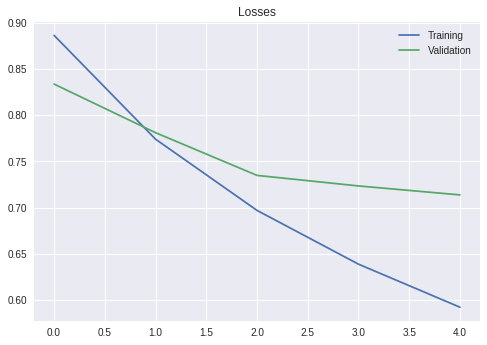

In [0]:
from matplotlib import pyplot as plt

fig1, ax1 = plt.subplots()

ax1.plot(t_losses, label='Training')
ax1.plot(v_losses, label='Validation')

ax1.set_title('Losses')
ax1.legend()

plt.show()

## Part B

Part B is similar to A with the following changes:
* We do not remove stopwords as we found that this decreased performance. Upon reflection, this was the expected behaviour as a numbe of stopwords such as "you" and "they" are very useful in predicting the target of the offensive language.

In [0]:
#Repeat for B
TOKENIZE_PARAMS_new = {"lemmatize": True, 
                   "rem_punct": True, #remove punctuation
                   "rem_stopwords": False}

#Initialize tokenizer function with these parameters 
def tokenizer_local(text):
    """wrapper for tokenize so it can be used in torchtext Field creation. It takes the 
    current global varaiable TOKENIZE_PARAMS_LCL"""
    try:
        params = TOKENIZE_PARAMS_new
    except NameError:
        print("You must initialize the global variable TOKENIZE_PARAMS_LCL")
        raise NameError
    return tokenize_params(text, params)

#The majority of what follows is repetition from part A and isn't, strictly, necessary.
#However, colab's namespace gets cluttered so we found it easier to re-initialize
#everything when building the vocab for each subtask by just running this cell.
#Poor software design for which we can only apologise...

TEXT = data.Field(sequential=True, tokenize=tokenizer_local, lower=True, batch_first = True)
LABEL = data.LabelField(sequential=False, use_vocab=True, batch_first = True)
ID = data.LabelField(sequential=False, use_vocab=False, batch_first=True)

data_fields = [('id', ID), 
               ('tweet', TEXT),
               ('subtask_a',LABEL),
               ('subtask_b',LABEL),
               ('subtask_c',LABEL)]

set_seed()

#Select data that does not have subtask_a == "OFF":
train = data.TabularDataset(train_fp, format='TSV', fields = 
                            data_fields, skip_header=True, filter_pred=lambda d: d.subtask_a == 'OFF')

train, valid = train.split(split_ratio=0.8, random_state=random.seed(SEED))

print(f'Train size: {len(train)}')
print(f'Validation size: {len(valid)}')

#Now build vocab (using only the training set)
TEXT.build_vocab(train, vectors='glove.twitter.27B.200d') 

LABEL.build_vocab(train.subtask_b)

output_dim = len(LABEL.vocab)

print(LABEL.vocab.stoi)

#Create iterators
train_iterator, valid_iterator = data.BucketIterator.splits((train, valid),
                        batch_sizes=(BATCH_SIZE, len(valid)),  
                        sort_key=lambda x: len(x.tweet), device=device)

train_df = pd.read_csv(train_fp, delimiter="\t")

Train size: 3520
Validation size: 880
defaultdict(<function _default_unk_index at 0x7f2c4ccd2400>, {'TIN': 0, 'UNT': 1})


In [0]:
#Conv with Glove Deep
embedding_dim = 200
window_size = 3
lr = 0.0001656545740852317
weight_decay = 0.0054326444080709255
out_channels = (128, 256)
dropout = 0
pos_weight = torch.tensor([6.8], device = device) #deals with unbalanced classes
n_hidden = (64, 32, 16, 8, 4)
sentiment = True

set_seed()

model_B = ClassifierGloVeDeepMultiConv(TEXT.vocab, embedding_dim, window_size = window_size, 
                            out_channels=out_channels, dropout=dropout, n_hidden = n_hidden, sentiment=sentiment)

optimizer = optim.Adam(model_B.parameters(), lr, weight_decay=weight_decay)
loss_fn = nn.BCEWithLogitsLoss(pos_weight = pos_weight)


t_losses, v_losses = train_helper('subtask_b', model_B, optimizer, loss_fn = loss_fn, epochs = 10, 
                                  train_loader=train_iterator, valid_loader=valid_iterator)



Epoch: 0
Iteration 0, loss = 1.6851

Validation Accuracy:


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Got 768 / 880 correct (87.27)
[[768   0]
 [112   0]]
              precision    recall  f1-score   support

           0       0.87      1.00      0.93       768
           1       0.00      0.00      0.00       112

   micro avg       0.87      0.87      0.87       880
   macro avg       0.44      0.50      0.47       880
weighted avg       0.76      0.87      0.81       880

Kappa: 0.0000
Epoch: 1
Iteration 0, loss = 1.3418

Validation Accuracy:
Got 767 / 880 correct (87.16)
[[766   2]
 [111   1]]
              precision    recall  f1-score   support

           0       0.87      1.00      0.93       768
           1       0.33      0.01      0.02       112

   micro avg       0.87      0.87      0.87       880
   macro avg       0.60      0.50      0.47       880
weighted avg       0.80      0.87      0.81       880

Kappa: 0.0108
Epoch: 2
Iteration 0, loss = 1.2065

Validation Accuracy:
Got 768 / 880 correct (87.27)
[[766   2]
 [110   2]]
              precision    recall  f1-score

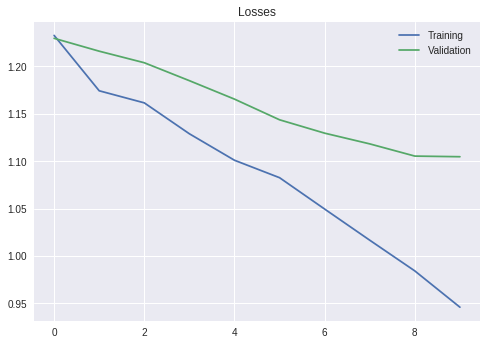

In [0]:
from matplotlib import pyplot as plt

fig1, ax1 = plt.subplots()

ax1.plot(t_losses, label='Training')
ax1.plot(v_losses, label='Validation')

ax1.set_title('Losses')
ax1.legend()

plt.show()

##Task C

Task C proved more difficult than A or B. Our ClassifierGloVeDeepMultiConv() was not able to generalization on this dataset. We eventually found that the original classifier OriginalClassifierGloVe() performed relatively well so used this instead. Post-rationalizing this: subtask C has a smaller training set so is not able to train the network that has more parameters. 

We found that it was not helpful to add sentiment and hypothesised that this was because a tweet's sentiment is likely independent of the who the offense is targeted at. 

In [0]:
TOKENIZE_PARAMS_new = {"lemmatize": True, 
                   "rem_punct": True, #remove punctuation
                   "rem_stopwords": False}

#Initialize tokenizer function with these parameters 
def tokenizer_local(text):
    """wrapper for tokenize so it can be used in torchtext Field creation. It takes the 
    current global varaiable TOKENIZE_PARAMS_LCL"""
    try:
        params = TOKENIZE_PARAMS_new
    except NameError:
        print("You must initialize the global variable TOKENIZE_PARAMS_LCL")
        raise NameError
    return tokenize_params(text, params)

TEXT = data.Field(sequential=True, tokenize=tokenizer_local, lower=True, batch_first = True)
LABEL = data.LabelField(sequential=False, use_vocab=True, batch_first = True)
ID = data.LabelField(sequential=False, use_vocab=False, batch_first=True)

data_fields = [('id', ID), 
               ('tweet', TEXT),
               ('subtask_a',LABEL),
               ('subtask_b',LABEL),
               ('subtask_c',LABEL)]

set_seed()


train = data.TabularDataset(train_fp, format='TSV', fields = 
                            data_fields, skip_header=True, filter_pred=lambda d: d.subtask_a == 'OFF' and d.subtask_b == 'TIN')

train, valid = train.split(split_ratio=0.8, random_state=random.seed(SEED))

print(f'Train size: {len(train)}')
print(f'Validation size: {len(valid)}')

#Now build vocab (using only the training set)
TEXT.build_vocab(train, vectors='glove.twitter.27B.200d') #USE "glove.840B.300d" or glove.twitter.27B.200d

LABEL.build_vocab(train.subtask_c)

output_dim = len(LABEL.vocab)

print(LABEL.vocab.stoi)

#Create iterators
train_iterator, valid_iterator = data.BucketIterator.splits((train, valid),
                        batch_sizes=(BATCH_SIZE, len(valid)),  
                        sort_key=lambda x: len(x.tweet), device=device)

Train size: 3101
Validation size: 775
defaultdict(<function _default_unk_index at 0x7f334c389620>, {'IND': 0, 'GRP': 1, 'OTH': 2})


In [0]:
#Conv with Glove Deep
embedding_dim = 200
window_size = 3
num_classes = 3
lr = 0.0001656545740852317
weight_decay = 0.0054326444080709255
out_channels = 128
dropout = 0.5
weight = torch.tensor([1.6, 3.7 ,8.4], device = device) #deals with unbalanced classes
n_hidden = (64, 32, 16, 8, 4)

sentiment = False

set_seed()
#vocab, embedding_dim, window_size, out_channels, dropout, num_classes=2, sentiment=False, n_hidden = 64
model_C = OriginalClassifierGloVe(TEXT.vocab, embedding_dim, window_size,
                            out_channels= out_channels, dropout=dropout, num_classes= num_classes )

optimizer = optim.Adam(model_C.parameters(), lr, weight_decay=weight_decay)
loss_fn = nn.CrossEntropyLoss(weight = weight)


t_losses, v_losses = train_helper('subtask_c', model_C, optimizer, loss_fn = loss_fn, epochs = 40, 
                                  train_loader=train_iterator, valid_loader=valid_iterator)

Epoch: 0
Iteration 0, loss = 2.0285

Validation Accuracy:
Got 437 / 775 correct (56.39)
[[312 163   1]
 [ 81 125   1]
 [ 37  55   0]]
              precision    recall  f1-score   support

           0       0.73      0.66      0.69       476
           1       0.36      0.60      0.45       207
           2       0.00      0.00      0.00        92

   micro avg       0.56      0.56      0.56       775
   macro avg       0.36      0.42      0.38       775
weighted avg       0.54      0.56      0.54       775

Kappa: 0.1934
Epoch: 1
Iteration 0, loss = 1.6601

Validation Accuracy:
Got 451 / 775 correct (58.19)
[[331 111  34]
 [ 76 104  27]
 [ 38  38  16]]
              precision    recall  f1-score   support

           0       0.74      0.70      0.72       476
           1       0.41      0.50      0.45       207
           2       0.21      0.17      0.19        92

   micro avg       0.58      0.58      0.58       775
   macro avg       0.45      0.46      0.45       775
weighted av

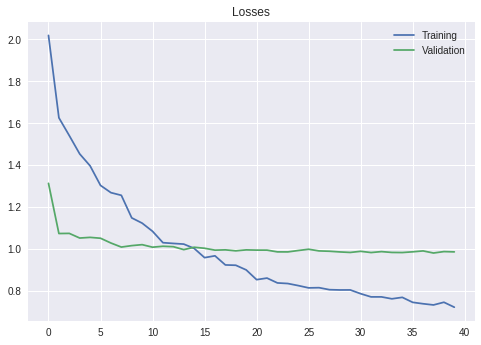

In [0]:
from matplotlib import pyplot as plt

fig1, ax1 = plt.subplots()

ax1.plot(t_losses, label='Training')
ax1.plot(v_losses, label='Validation')

ax1.set_title('Losses')
ax1.legend()

plt.show()

## Output predictions

In [0]:
#Use this helper function to output predictions

label_dict_A = {0: "NOT", 1: "OFF"}
label_dict_B = {0: 'TIN', 1: 'UNT'} 
label_dict_C = {0: 'IND', 1: 'GRP', 2: 'OTH'}

#Function to oputput predictions to CSV
def output_prediction_csv(fp, model, test_loader, task_header, label_dict, RNN=False):
    """Outputs CSV to filepath fp"""
    model.eval()  # set model to evaluation mode
    model = model.to(device="cpu")  # move the model parameters to GPU

    with torch.no_grad():
        for idx, batch in enumerate(test_loader):
            x = batch.tweet
            ids = batch.id
            if x.device != "cpu":
                x = x.to(device="cpu", dtype=torch.long)  # move to  GPU
            if ids.device != "cpu":
                ids = ids.to(device="cpu")
            
            if RNN:
                #Must zero all of the accumalated hidden state for the RNN
                model.hidden = model.init_hidden(batch.batch_size)
   
            logits = model(x, ids)
            if task_header == 'subtask_c':
                pred_prob = F.softmax(logits, dim=1)
                predictions = torch.argmax(pred_prob, dim=1).view(-1, 1).numpy()
            else:
                pred_prob = torch.sigmoid(logits)
                pred_1 = (pred_prob > 0.5).numpy()
                predictions = pred_1.astype(int)
            out_np = np.concatenate([ids.numpy().reshape((-1, 1)), predictions], axis=1)
            df = pd.DataFrame(out_np)
            df[1] = df[1].map(label_dict)
            df.to_csv(fp, header=False, index=False)